# Introduction

Ce notebook présente une approche pour déterminer le genre d'une musique à travers les caractéristiques fournies par l'API spotify en utilisant des algorithmes de Machine Learning. Il s'agit d'une version simplifiée du notebook `final_nootebook` dans lequel les fonctions utilisées ne sont pas détayées mais stockées dans utils. Les hyperparamètres des modèles ont également état optimisés. Ce projet s'intègre dans le cadre du cours Python pour la Data Science de l'ENSAE Paris. Il a été mené par Tom Laflotte, Enzo Moran et Martin Conte.

Il suit le plan suivant:

I. Une première approche via l'API Spotify

1. Collecte des données

    a. Constitution d'un premier dataset
    
    b. Collecte du genre des artistes

2. Visualisation

II. Prédiction à l'aide d'une base de données Kaggle 

1. Préparation des données

    a. Gestion des valeurs

    b. Standardisation des variables continues

    c. Imputation des valeur manquantes

    d. Imputation des variables catégorielles *

2. Visualisation des données préparées

    a. Analyse multivariée

    b.Vérification du poids des variables

3. Modélisation

    a. Random Forest

    b. XGBoost

    c. Catboost

Conclusion





In [1]:
!pip install spotipy
!pip install numpy==1.26.4
!pip install catboost

In [2]:
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns

# I. Une première approche via l'API Spotify

Tout d'abord nous devons importer toutes les librairies qui nous seront nécessaires pour cette partie

## I.1. Collecte des données

Nous avons d'abord essayé de créer une base de données grâce à l'API Spotify. Cette base de données ne sera pas utilisée ensuite pour la modélisation, en effet du jour au lendemain, fin novembre, l'API Spotify a restreint l'accès à certaines données clés pour notre projet et ceci avant que notre projet ne soit finalisé, d'où la nécessité en partie II d'utiliser une base de données Kaggle.

### I.1.a. Constitution d'un premier dataset

Spotify ne met pas à disposition une quelconque base de donnée déjà constituée. Nous allons donc devoir faire des requêtes successives à l'API pour récolter les informations sur les morceaux choisis, afin de constituer notre premier dataset. Chaque requête permet d'obtenir les metadonnées d'un artiste donné, ou d'une playlist donnée. C'est ce que nous avons choisi de faire.

Pour minimiser le nombre de requêtes, nous sélectionnons une playlist de 10 000 morceaux déjà faite par un utilisateur Spotify, afin d'obtenir des informations sur chaque morceau qui la compose : titre, id, artist, artist_id. Ensuite, nous récupérons les informations qui nous intéressent sur chaque morceau : les track features, qui sont un tas d'indices quantitatifs. Enfin, nous récupérons le genre qui n'est associé qu'à l'artiste, et pas au morceau. C'est ici une limite préoccupante : le genre qui est la variable à prédire n'est en fait que le genre de l'artiste et pas le genre véritable du morceau.

D'abord, on initialise le client Spotify pour l'obtention des données via l'API grâce au token d'accès avec la fonction `spotify_client`.

Ensuite, nous utilisons ce client pour notre requête sur la playlist de 10 000 morceaux.

Notre objectif final est d'obtenir un fichier csv compilant toutes les données fournies par l'API de Spotify dans un fichier csv.
Nous réalisons cela grâce à la fonction `get_playlist_data_to_csv`. Celle-ci fait appel à des fonctions intermédiaires:

- `fetch_playlist_tracks` permet d'obtenir des informations sur l'ensemble des musiques d'une playlist
- `fetch_artist_genre` permet d'obtenir le genre principal d'un 
- `fetch_track_data` permet de récupérer les informations qui seront utile à le modélisation
- `save_to_csv` enregistre le tout au csv


Du fait des restrictions de requêtes imposées par l'API de spotify, nous avons mis en place des requêtes par paquets de 100 chansons suivi d'une pause d'une minute, cette approche nous a permis de constituer une première base de données de 1500 musiques, en répétant ce procédé sur une plus longue période, il serait possible d'obtenir les données de l'ensemble de la playlist mais comme nous le détaillerons plus tard, nous n'avons pas retenu cette approche et nous contenterons de la base de données intermédiaire.

La requête suivante permet de constituer un premier dataset consitué des musiques de la playlist "Top 10 000 songs of All-Time":

`get_playlists_data_to_csv(['1G8IpkZKobrIlXcVPoSIuf'])`

### I.1.b. Collecte du genre de la playlist

Nous avons réussi à enregistrer une première version de notre df que nous visualiserons en partie I. 2. Cependant, cette approche ne nous donne que le genre de l'artiste et pas nécessairement de la playlist. C'est pourquoi nous avons décidé d'adapter certaines de nos fonctions afin de collecter le genre des playlists et de collecter les données de playlists aux genres spécifiques. Le genre de la playlist sera ensuite assimilé à celui de l'artiste. A cet effet, nous avons ajouté la fonction `get_playlist_data_to_csv_with_genre`

`get_playlists_data_to_csv_with_genre({'rap' : '4KsrGBWG6gzBwGe9dx16OE', 
                                      'country' : '33mU9g6y8nKFAOyiISor0G',
                                      'blues' : '7BDUphylF8dfPKFo9Tvdr9',
                                      'metal' : '1yYEy4MtNLVScj74wcPR7w',
                                      'r_and_b' : '7CI3NR7rvCkgiLhch1qprf',
                                      'classical_music' : '5n9btvMZ52rxwozhQdKU7v',
                                      'jazz' : '79Bcltku1dcD08JcAM29kL',
                                      'pop' : '7gqtGYFoCR3tAqTtEUQZTw'})`

Cette deuxième approche nous aurait permis de constituer un dataset plus précis mais nous n'avons pas pu la mettre en place. En effet, les conditions d'utilisation de l'API spotify ont été changées et il n'est plus possible de faire des requêtes donnant accès aux métadonnées des chansons. Notre Machine Learning utilisera donc un dataset Kaggle. Néanmoins, nous pouvons visualiser les données collectées en partie I.1.a

## I.2. Visualisation

Nous utilisons dans cette première partie la base de données constituée avec la méthode de la partie I.1 que nous avons stocké sur SSPCloud

In [3]:
file_path = "/ponte/Projet_data/first_db.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

In [4]:
df.head()

,track Name,artists,track_id,popularity,duration_ms,explicit,genre,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature
0,Like a Rolling Stone,Bob Dylan,3AhXZa8sUQht0UEdBJgpGc,69,369600,False,classic rock,0.482,0.721,0,...,0.000000,0.1890,0.557,95.263,audio_features,3AhXZa8sUQht0UEdBJgpGc,spotify:track:3AhXZa8sUQht0UEdBJgpGc,https://api.spotify.com/v1/tracks/3AhXZa8sUQht...,https://api.spotify.com/v1/audio-analysis/3AhX...,4
1,Smells Like Teen Spirit,Nirvana,3oTlkzk1OtrhH8wBAduVEi,0,300977,False,grunge,0.485,0.863,1,...,0.016200,0.1380,0.767,116.835,audio_features,3oTlkzk1OtrhH8wBAduVEi,spotify:track:3oTlkzk1OtrhH8wBAduVEi,https://api.spotify.com/v1/tracks/3oTlkzk1Otrh...,https://api.spotify.com/v1/audio-analysis/3oTl...,4
2,A Day In The Life - Remastered,The Beatles,3ZFBeIyP41HhnALjxWy1pR,0,337413,False,british invasion,0.364,0.457,4,...,0.000106,0.9220,0.175,163.219,audio_features,3ZFBeIyP41HhnALjxWy1pR,spotify:track:3ZFBeIyP41HhnALjxWy1pR,https://api.spotify.com/v1/tracks/3ZFBeIyP41Hh...,https://api.spotify.com/v1/audio-analysis/3ZFB...,4
3,Good Vibrations (Mono),The Beach Boys,5Qt4Cc66g24QWwGP3YYV9y,17,219147,False,baroque pop,0.398,0.413,1,...,0.000025,0.0891,0.331,133.574,audio_features,5Qt4Cc66g24QWwGP3YYV9y,spotify:track:5Qt4Cc66g24QWwGP3YYV9y,https://api.spotify.com/v1/tracks/5Qt4Cc66g24Q...,https://api.spotify.com/v1/audio-analysis/5Qt4...,4
4,Johnny B Goode,Chuck Berry,7MH2ZclofPlTrZOkPzZKhK,0,160893,False,blues,0.518,0.756,10,...,0.000062,0.3170,0.968,166.429,audio_features,7MH2ZclofPlTrZOkPzZKhK,spotify:track:7MH2ZclofPlTrZOkPzZKhK,https://api.spotify.com/v1/tracks/7MH2ZclofPlT...,https://api.spotify.com/v1/audio-analysis/7MH2...,4


### I.2.a. Pré-Nettoyage

On supprime les colonnes de la database servant uniquement à identifier les musiques:


In [5]:
df=df.drop(['track Name','track_id','type','id','uri','track_href', 'analysis_url'],axis=1)

Il semble qu'il y ait de nombreux genres musicaux qui en réalité pourraient être considérés comme des sous-genres, nous allons donc les regrouper.

In [6]:
genres=df['genre'].unique().tolist()
print(genres)

['classic rock', 'grunge', 'british invasion', 'baroque pop', 'blues', 'classic soul', 'brill building pop', 'album rock', 'r&b', 'rock-and-roll', 'heartland rock', 'alternative rock', 'atl hip hop', 'escape room', 'bronx hip hop', 'adult standards', 'art rock', 'funk', 'motown', 'pop', 'acid rock', 'classic garage rock', 'dance pop', 'disco', 'madchester', 'britpop', 'downtempo', 'conscious hip hop', 'east coast hip hop', 'alternative dance', 'classic girl group', 'art pop', 'lilith', 'glam metal', 'blues rock', 'chicago rap', 'electro', 'beatlesque', 'piano rock', 'irish rock', 'europop', 'lgbtq+ hip hop', 'british soul', 'reggae', 'french shoegaze', 'country', 'big beat', 'barbadian pop', 'mellow gold', 'candy pop', 'canadian hip hop', 'classic soundtrack', 'american folk revival', 'garage rock', 'australian psych', 'afrofuturism', 'g funk', 'new romantic', 'australian dance', 'brooklyn indie', 'dusseldorf electronic', 'arkansas country', 'irish punk', 'louisiana blues', 'acoustic b

In [7]:
categories = {
    "rap": [
        'hip hop', 'rap', 'dirty south rap', 'melodic rap', 'conscious hip hop', 'alternative hip hop', 'chicago rap', 
        'bronx hip hop', 'detroit hip hop', 'gangster rap', 'canadian hip hop', 'atl hip hop', 'lgbtq+ hip hop', 'bboy', 'hip pop'
    ],
    "rock": [
        'classic rock', 'album rock', 'alternative rock', 'dance rock', 'hard rock', 'soft rock', 'irish rock', 'piano rock', 
        'australian rock', 'detroit rock', 'british blues', 'garage rock', 'classic garage rock', 'glam rock', 'art rock', 
        'alternative metal', 'folk rock', 'country rock', 'protopunk', 'space rock', 'experimental rock', 'modern rock', 
        'surf music', 'pub rock', 'new wave', 'dance-punk'
    ],
    "pop": [
        'pop', 'dance pop', 'pop rock', 'ambient pop', 'alternative pop', 'bedroom pop', 'canadian pop', 'british soul', 
        'classic country pop', 'barbadian pop', 'bubblegum pop', 'torch song', 'french shoegaze', 'new wave pop', 
        'brill building pop', 'beatlesque', 'britpop', 'art pop', 'candy pop','power pop','electropop', 'experimental pop'
    ],
    "blues": [
        'blues', 'blues rock', 'classic soul', 'r&b', 'british blues', 
        'louisiana blues', 'acoustic blues'
    ],
    "jazz":['cool jazz', 'bebop', 
        'avant-garde jazz', 'big band', 'hot jazz', 'jazz blues', 'gospel', 'soul jazz'],
    "country": [
        'folk', 'american folk revival', 'appalachian folk', 'ambient folk', 'bluegrass', 'bluegrass gospel', 'celtic punk', 
        'country', 'country rock', 'bakersfield sound', 'arkansas country', 'cowboy western', 'alternative americana'
    ],
    "electro": [
        'edm', 'house', 'acid house', 'ambient', 'ambient house', 'ambient pop', 'dance-punk', 'electro', 'indietronica', 
        'balearic', 'atmospheric dnb', 'filter house', 'hi-nrg', 'big beat'
    ],
    "classical": [
        'african-american classical', 'baroque pop', 'torch song', 'classic soundtrack', 'adult standards'
    ]
}


In [8]:
def assign_category(genre):
    for category, keywords in categories.items():
        if genre in keywords:
            return category
        elif genre=='N/A':
            return 
    return "other"

df["category"] = df["genre"].apply(assign_category)

### I.2.b Visualisation des données

Analysons tout d'abord les variables catégoriques de notre dataset:

In [9]:
categorical_var = df.copy().select_dtypes(include=["object"]).columns.to_list()
categorical_var.extend(["key","mode","time_signature","explicit"])

In [10]:
df[categorical_var].nunique()

artists           822
genre             198
category            9
key                12
mode                2
time_signature      4
explicit            2
dtype: int64

Pour les variables avec un faible nombre de valeurs différentes, nous allons les représenter sous forme d'histogramme

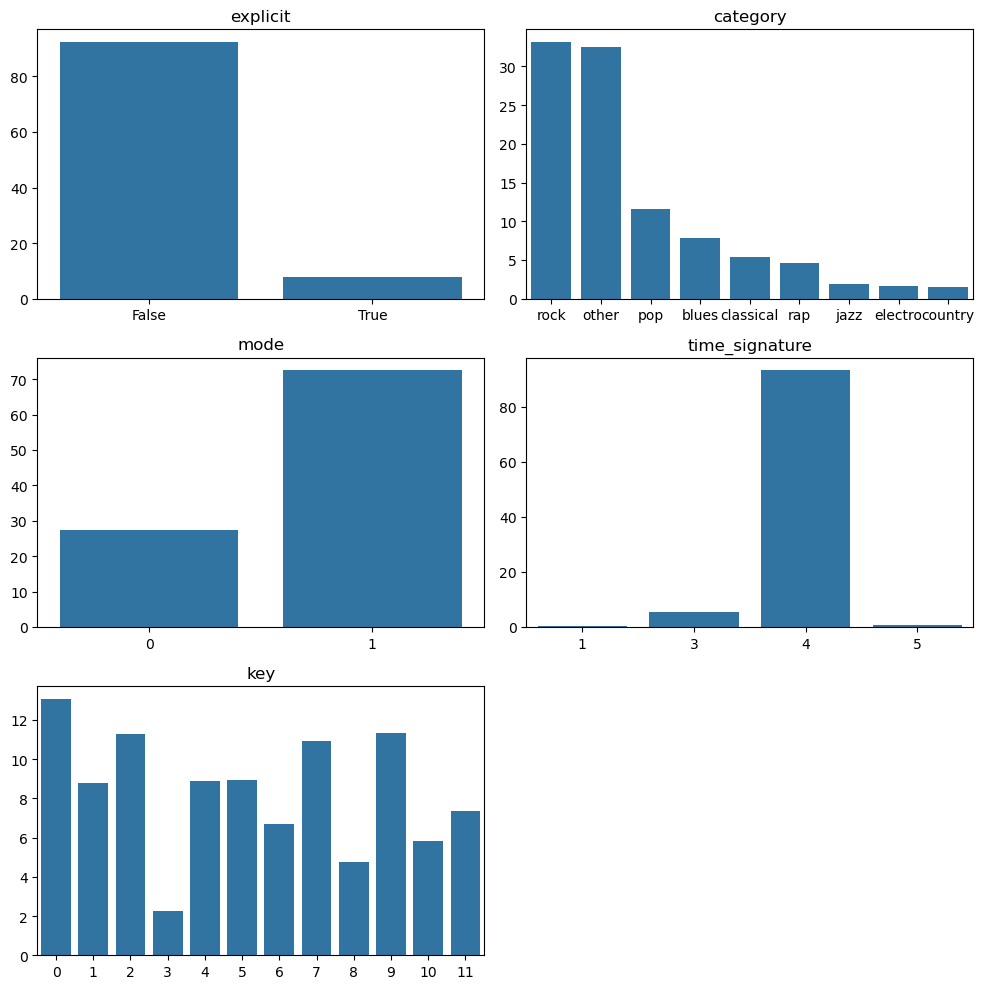

In [11]:
df_barplot = df[["explicit","category","mode","time_signature","key"]].copy()
plt.figure(figsize=(10,10))

for c,var in enumerate(df_barplot.columns):
  # compute frequency of each unique value
  df_plot= df_barplot[var].value_counts(normalize=True).to_frame("frequency").reset_index(names=var)
  df_plot["frequency"] = df_plot["frequency"]*100

  # plot the barplot
  plt.subplot(3,2,c+1)
  sns.barplot(data=df_plot, x=var, y="frequency")
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

Nous observons que la catégorie qui est le regroupement du genre est très mal répartie, cela risque de poser problème pour notre modèle car il s'agit de la variable cible qui devrait donc être répartie de façon uniforme afin de ne pas créer de biais dans notre modèle.

Pour les colonnes 'artists' et 'genre' nous allons visualiser le top10 des artistes les plus représentés

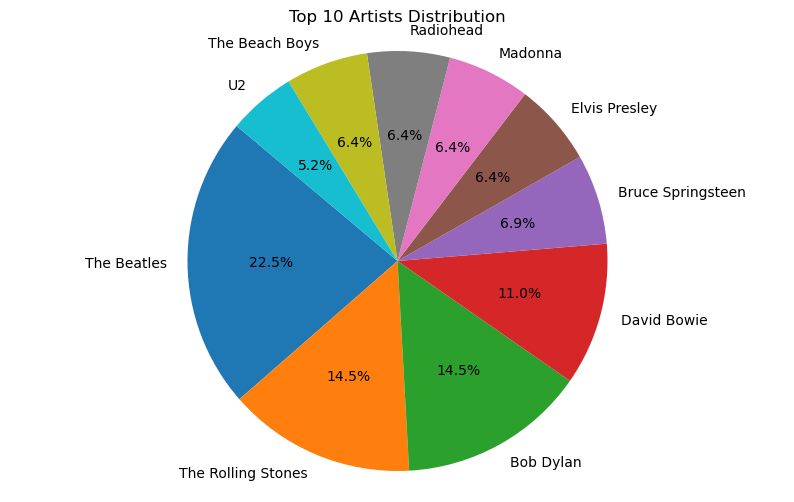

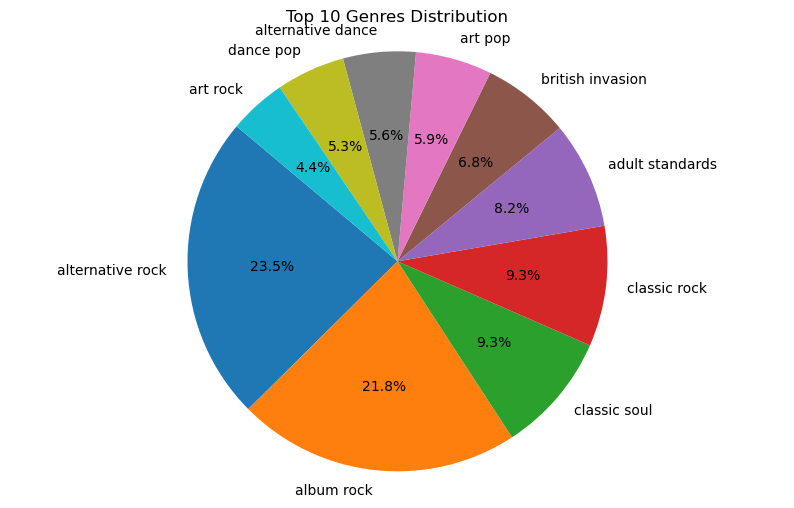

In [12]:
# Pie chart for 'artists'
artist_counts = df['artists'].value_counts().head(10) 
plt.figure(figsize=(10, 6))
plt.pie(artist_counts, labels=artist_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Artists Distribution')
plt.axis('equal')  
plt.show()

# Pie chart for 'genre'
genre_counts = df['genre'].value_counts().head(10)  
plt.figure(figsize=(10, 6))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Genres Distribution')
plt.axis('equal')  
plt.show()

De même, la répartition des genres dans notre dataset n'est pas adaptée à notre problématique. Nous avons donc tenté l'approche détaillée en partie I.1.b. qui s'est avérée infructueuse du fait d'un changement de la politique de Spotify https://developer.spotify.com/blog/2024-11-27-changes-to-the-web-api nous allons donc, pour la suite utiliser un dataset de 30 000 musiques issu du site Kaggle https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs

# II. Prédiction à l'aide d'une base de données Kaggle

Comme l'API Spotify a bloqué l'accès aux caractéristiques de toutes ces musiques à compter de la fin de ce mois de novembre 2024 (en effet tous les paramètres tels que danceabilty, liveness, tempo... se sont retrouvés inaccessibles du jour au lendemain), nous n'avons pu finaliser notre propre base de données à temps. Ainsi, le choix a été fait de se limiter à une base de donnés Kaggle pour notre projet. Ce dataset possède 30 000 lignes et indique les caractéristiques des musiques qui nous intéressent ainsi que leur genre grâce à la playlist d'où ils proviennent. 

Nous nous occuperons dans un premier temps de nettoyer les données et de les mettre en forme, avant de visualiser les variables et tester leur pertinence dans notre modèle. Enfin, nous essaierons à partir de ce qui a été fait de mettre en place un modèle permettant de prédire le genre d'une musique grâce à ses caractéristiques.

## II.1. Préparation des données


Dans cette partie nous allons nous occuper du preprocess c'est à dire du nettoyage et de la mise en forme des données en vue de la création du modèle

Importation des modules nécessaires : 

In [13]:
file_path = "/tlaflotte/genre_detector/spotify_tracks.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

On commence par éliminer toutes les colonnes qui contiennent des noms et des identifiants et qui n'apportent donc aucune information intéressante pour notre étude. Nous choisissons aussi de supprimer la colonne popularity car celle-ci est calculée de façon très obscure et comporte de trop nombreuses valeurs nulles pour les imputer alors même que les chansons sont célèbres.

In [14]:
df.drop(columns=["track_name","track_id","track_artist","track_album_id","track_album_name","track_album_release_date",
       "playlist_name", "playlist_id","track_popularity"], inplace = True)

### II.1.a Gestion des valeurs aberrantes 

D'abord, on va s'occuper des outliers. On va les identifier avec la méthode du z-score en considérant comme outliers les valeurs ayant un Zscore en valeur absolue supérieur à 3. On peut se permettre cela car les distributions de la plupart des variables sont proches de gaussiennes (voir-ci dessous), même si certaines variables font exceptions notamment tempo, valence et track_popularity.

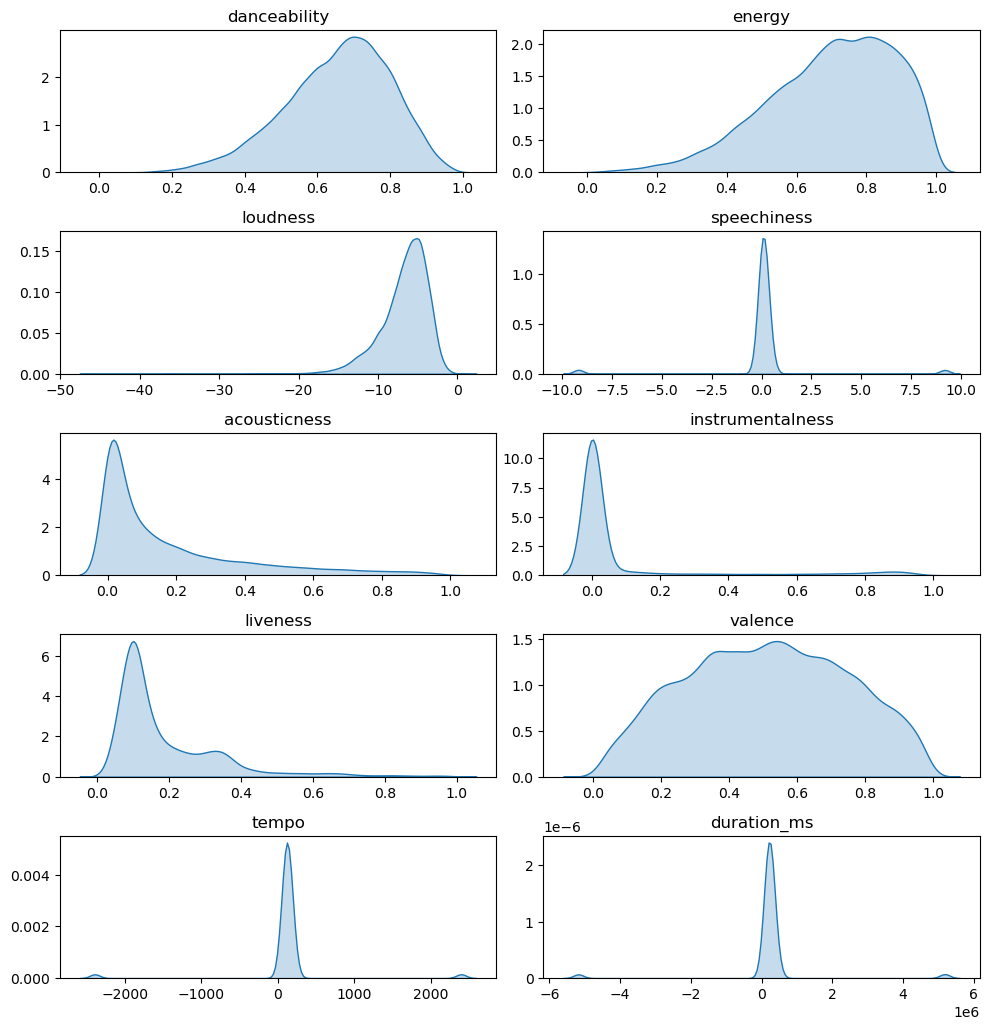

In [15]:
continuous_var = [
       'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

La fonction count_outliers_zscore ci-dessous nous permet de calculer les outliers par rapport à un seuil, fixé à 3 par défaut.

In [16]:
outliers_zscore = count_outliers_zscore(df)

count_outliers_zscore(df)


danceability         123
energy               166
key                    0
loudness             368
mode                   0
speechiness         1641
acousticness         657
instrumentalness    1692
liveness               0
valence                0
tempo               1641
duration_ms         1641
dtype: int64

On identifie un petit nombre d'outliers et rien ne nous indique que ces valeurs sont absurdes ou fausses et non juste des valeurs qui sortent un peu de l'ordinaire. Ainsi plutôt que de supprimer les lignes en question, on va plutôt winsorizer les valeurs. La fonction winsorize_outliers permet justement de faire cela, on va appliquer cette fonction à toutes les colonnes continues, toujours avec un seuil de 3

In [17]:
df_winsorized = winsorize_outliers(df, ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo','duration_ms'], 3)

In [18]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,31028.000000,31849.000000,32833.000000,3.283300e+04
mean,0.654850,0.698619,5.374471,-6.719499,0.565711,0.093718,0.175334,0.084747,0.189994,0.510953,115.492037,2.223588e+05
std,0.145085,0.180910,3.611657,2.988436,0.495671,2.055226,0.219633,0.224230,0.154279,0.232926,536.453234,1.158704e+06
min,0.000000,0.000175,0.000000,-46.448000,0.000000,-9.180000,0.000000,0.000000,0.009360,0.000000,-2394.400000,-5.178100e+06
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.040200,0.015100,0.000000,0.092700,0.331000,98.231000,1.863330e+05
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062600,0.080400,0.000016,0.127000,0.512000,121.985000,2.162560e+05
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.139000,0.255000,0.004830,0.248000,0.693000,135.290000,2.567570e+05
max,0.983000,1.000000,11.000000,1.275000,1.000000,9.180000,0.994000,0.994000,0.996000,0.991000,2394.400000,5.178100e+06


In [19]:
df_winsorized.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,31028.000000,31849.000000,32833.000000,32833.000000
mean,0.654991,0.698879,5.374471,-6.689571,0.565711,0.124361,0.174019,0.079160,0.189994,0.510953,120.370004,228054.461700
std,0.144626,0.180072,3.611657,2.860485,0.495671,0.160875,0.215375,0.204893,0.154279,0.232926,36.023518,82372.437855
min,0.220000,0.156000,0.000000,-15.682000,0.000000,0.000000,0.000000,0.000000,0.009360,0.000000,0.000000,4000.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.040200,0.015100,0.000000,0.092700,0.331000,98.231000,186333.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062600,0.080400,0.000016,0.127000,0.512000,121.985000,216256.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.139000,0.255000,0.004830,0.248000,0.693000,135.290000,256757.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.833000,0.757000,0.996000,0.991000,220.252000,517810.000000


On remarque ainsi que certaines valeurs extrêmes ont été modifiées, sans que les statistiques les plus basiques (moyenne, variance, médiane et quartiles) ne soient significativement impactées. On peut donc remplacer notre tableau par ce nouveau tableau winsorisé.

In [20]:
df = df_winsorized

### II.1.b Standardisation des variables continues 

Ensuite, pour continuer de mettre en forme le dataset pour que notre modèle de prédiction du genre soit performant, il est nécessaire de standardiser les variables continues 

In [21]:
columns_to_standardize = ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'duration_ms']

scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[columns_to_standardize] = scaler.fit_transform(df_standardized[columns_to_standardize])

Vérifions désormais que les colonnes de df_standardized sont bel et bien standardisées, avant de remplacer df par ce nouveau
tableau 

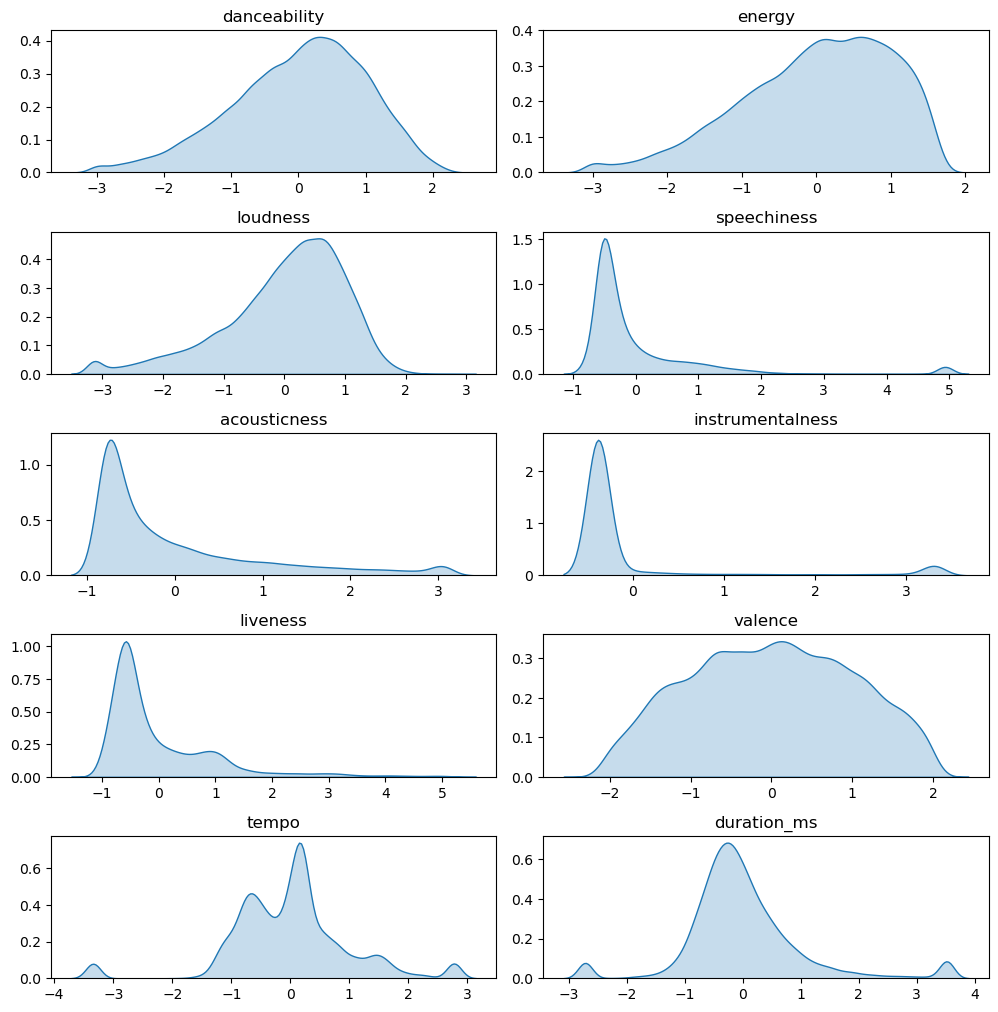

In [22]:
plt.figure(figsize=(10,12))

for c,var in enumerate(continuous_var):
  plt.subplot(6,2,c+1)
  sns.kdeplot(data=df_standardized[continuous_var], x=var, fill=var)
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")
    
plt.tight_layout()

In [23]:
# Calculons plutôt la moyenne et la variance des colonnes standardisées
for col in columns_to_standardize:
    mean = df_standardized[col].mean()
    variance = df_standardized[col].var()
    print(f"Variable : {col}")
    print(f"Moyenne : {mean:.6f}")
    print(f"Variance : {variance:.6f}\n")

Variable : danceability
Moyenne : 0.000000
Variance : 1.000030

Variable : energy
Moyenne : 0.000000
Variance : 1.000030

Variable : loudness
Moyenne : -0.000000
Variance : 1.000030

Variable : speechiness
Moyenne : -0.000000
Variance : 1.000030

Variable : acousticness
Moyenne : 0.000000
Variance : 1.000030

Variable : instrumentalness
Moyenne : 0.000000
Variance : 1.000030

Variable : liveness
Moyenne : -0.000000
Variance : 1.000032

Variable : valence
Moyenne : -0.000000
Variance : 1.000031

Variable : tempo
Moyenne : 0.000000
Variance : 1.000030

Variable : duration_ms
Moyenne : -0.000000
Variance : 1.000030



Les courbes ont gardé leur forme, ce qui nous permet de dire que la standardisation n'a pas affecté la distribution des valeurs. En revanche, les légendes des graphiques sont insuffisantes pour conclure sur la valeur de la moyenne et de la variance. Cependant, les calculs de moyenne et de variance ne laissent pas de doute, la standardisation est réussie. On peut donc remplacer df par notre nouveau tableau aux variables continues standardisées.

In [24]:
df = df_standardized

### II.1.c Imputation des valeur manquantes

Maintenant, il est bien sûr nécessaire de calculer les valeurs manquantes (NaNs). Remplacer par la moyenne ou la médiane semblait réducteur, on a donc décidé de tester 3 modèles différents et de les comparer afin de décider de quel modèle choisir pour imputer nos valeurs manquantes.

In [25]:
df.isna().sum()

playlist_genre          0
playlist_subgenre       0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness             1805
valence               984
tempo                   0
duration_ms             0
dtype: int64

Nous devons imputer les valeurs manquantes dans 2 colonnes : liveness et valence. Nous allons pour cela comparer 3 modèles, la régression linéaire, random forest et Xgboost. 
Ainsi, pour notre comparaison, pour chaque modèle nous allons faire un test (en divisant notre jeu de données), et alors nous calculerons à la fois :
- La MAE (Erreur absolue Moyenne) qui mesure la moyenne des écarts absolus entre les valeurs prédites par le modèle et les valeurs réélles
- Le R2 (Coefficient de détermination) mesurant la proportion de variance des données expliquée par le modèle.

Les résultats vont nous permettre de savoir quel modèle est le plus performants entre les 3. C'est avec ce modèle que nous ferons donc la prédiction des valeurs manquantes dans les colonnes liveness et tempo
Nous allons naïvement utiliser toutes les autres variables (à l'exception de playlist-genre et playlist_subgenre) comme variables prédictives.

In [26]:
predictors = [ 'speechiness', 'instrumentalness', 'energy', 'danceability', 'acousticness', 'tempo', 
              'duration_ms', 'loudness', 'key', 'mode']

#### Avec une régression linéaire : 

La fonction `impute__with_linear_regression` permet justement d'imputer les valeurs manquantes avec une régression linéaire ainsi que de calculer directement la MAE et le R2.

In [27]:
impute_with_linear_regression(df, 'liveness', predictors)

impute_with_linear_regression(df, 'valence', predictors)

liveness - MAE : 0.7080, R^2 : 0.0461
valence - MAE : 0.7263, R^2 : 0.2139


Les résultats ne sont pas satisfaisants, les erreurs moyennes absolues sont assez éloignées de 1 et les coefficients de détermination sont faibles.

#### Avec random forest : 

la fonction `impute_with_random_forest` permet de calculer les NaN avec un modèle random forest et la fonction `test_random_forest_imputation` permet de calculer la MAE et le R2.

In [28]:
df_intermediary = impute_with_random_forest(df, target_column='liveness', predictors=predictors)

df_rf = impute_with_random_forest(df_intermediary, target_column='valence', predictors=predictors)


In [29]:
mae_liveness, r2_liveness = test_random_forest_imputation(df, target_column='liveness', predictors=predictors)
print(f"Liveness - MAE : {mae_liveness:.4f}, R^2 : {r2_liveness:.4f}")

mae_valence, r2_valence = test_random_forest_imputation(df, target_column='valence', predictors=predictors)
print(f"Valence - MAE : {mae_valence:.4f}, R^2 : {r2_valence:.4f}")

Liveness - MAE : 0.6237, R^2 : 0.1884
Valence - MAE : 0.5715, R^2 : 0.4373


Les valeurs, quoique loin d'être parfaites, sont déjà plus satisfaisantes 

#### Avec xgboost : 

La fonction `impute__with_xgboost` permet d'imputer les valeurs manquantes avec xgboost. La fonction `evaluate_xgboost_model` permet quant à elle de calculer la MAE et le R2

In [30]:
df_intermediary_xg, liveness_model = impute_with_xgboost(df, target_col='liveness', predictors=predictors)

df_xg, valence_model = impute_with_xgboost(df_intermediary_xg, target_col='valence', predictors=predictors)

In [31]:
mae_liveness, r2_liveness = evaluate_xgboost_model(df_intermediary_xg, liveness_model, 'liveness', predictors)
print(f"Liveness - MAE: {mae_liveness:.4f}, R^2: {r2_liveness:.4f}")

mae_valence, r2_valence = evaluate_xgboost_model(df_xg, valence_model, 'valence', predictors)
print(f"Valence - MAE: {mae_valence:.4f}, R^2: {r2_valence:.4f}")

Liveness - MAE: 0.6493, R^2: 0.0885
Valence - MAE: 0.6535, R^2: 0.3282


Les valeurs sont encore une fois décevantes, et moins satisfaisantes encore qu'avec random forest.

Ainsi, en se basant sur le R2 et la MAE c'est avec le random forest que l'on obtient les meilleures résultats c'est à dire les plus petites MAE et les plus grands R2. C'est donc avec ce modèle qu'on va imputer les NaNs.

In [32]:
df = df_rf

### II.1.d Imputation des variables catégorielles 

Même si nous sommes que peu sûr d'utiliser cette variable plus tard (en effet cette variable semble trop bien caractériser le genre et cela n'aurait que peu de sens de l'utiliser pour le prédire), nous allons nous occuper de l'encodage de la variable subgenre.

Avant tout visualisons nos 4 variables catégorielle pour vérifier qu'il n'y a que subgenre à encoder.

In [33]:
categorical_var = ['playlist_genre', 'playlist_subgenre', 'key', 'mode']
df[categorical_var].nunique()

playlist_genre        6
playlist_subgenre    24
key                  12
mode                  2
dtype: int64

La variable mode est binaire donc ne nécessite aucun encodage, et la variable key prend 12 valeurs différentes qui sont les entiers de 0 à 11, ils ne semblent donc pas nécessaire de les encoder. 
Évidemment, nous n'allons pas encoder la variable playlist_genre que nous cherchons à prédire.

Intéressons nous donc à la variable playlist_subgenre, qui contient trop de vavleurs différentes pour être encodé en créant de nouvelles variables.

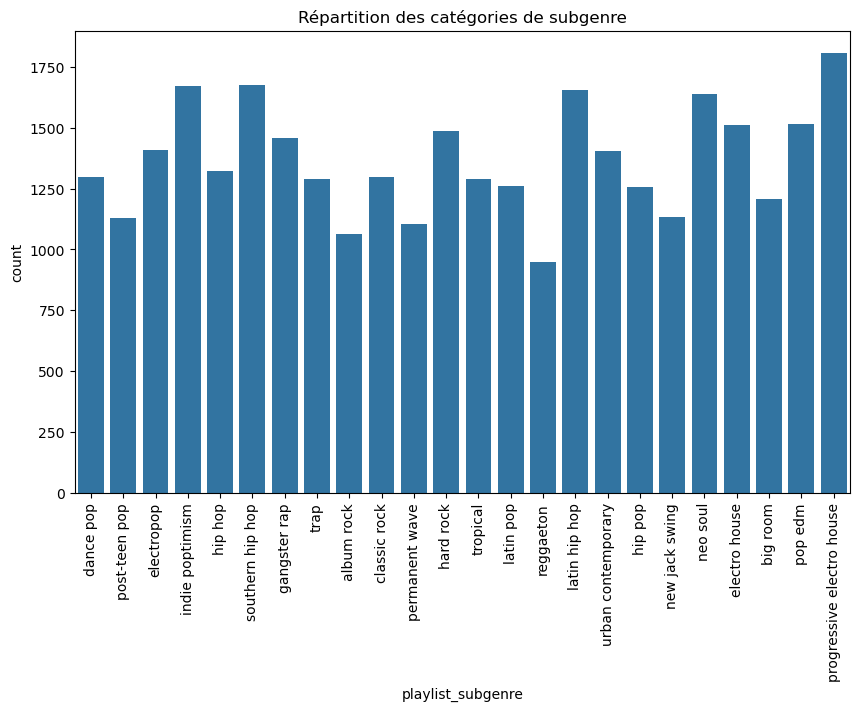

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(x='playlist_subgenre', data=df)
plt.title('Répartition des catégories de subgenre')
plt.xticks(rotation=90)
plt.show()

In [35]:
print(df['playlist_subgenre'].value_counts(normalize=True))

playlist_subgenre
progressive electro house    0.055097
southern hip hop             0.051016
indie poptimism              0.050924
latin hip hop                0.050437
neo soul                     0.049858
pop edm                      0.046204
electro house                0.046021
hard rock                    0.045229
gangster rap                 0.044407
electropop                   0.042884
urban contemporary           0.042792
hip hop                      0.040264
dance pop                    0.039533
classic rock                 0.039472
trap                         0.039320
tropical                     0.039229
latin pop                    0.038437
hip pop                      0.038254
big room                     0.036731
new jack swing               0.034508
post-teen pop                0.034386
permanent wave               0.033655
album rock                   0.032437
reggaeton                    0.028904
Name: proportion, dtype: float64


Les subgenre ont tous des proportions différentes, on peut ainsi les encoder en créant une nouvelle colonne playlist_subgenre_encoded qui contient la proportion du subgenre dans le dataset, cette colonne permet d'identifier le subgenre, on peut donc supprimer lea colonne subgenre. On a désormais des valeurs numériques.

In [36]:
df_encoded = df.copy()

subgenre_proportions = df_encoded['playlist_subgenre'].value_counts(normalize=True)
df_encoded['playlist_subgenre_encoded'] = df_encoded['playlist_subgenre'].map(subgenre_proportions)
df_encoded = df_encoded.drop(columns=['playlist_subgenre'])

df_encoded.head()

,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist_subgenre_encoded
0,pop,0.643106,1.205761,6,1.417813,1,-0.410645,-0.334394,-0.386352,-0.808248,0.030257,0.046248,-0.404273,0.039533
1,pop,0.490988,0.644866,11,0.601505,1,-0.541183,-0.471831,-0.365805,1.082508,0.781581,-0.566250,-0.794628,0.039533
2,pop,0.138349,1.289062,1,1.138835,0,-0.311809,-0.439329,-0.386238,-0.518509,0.438119,0.100991,-0.624472,0.039533
3,pop,0.435672,1.283509,7,1.017875,1,-0.139001,-0.674736,-0.386306,0.090785,-1.004425,0.044027,-0.715802,0.039533
4,pop,-0.034513,0.744828,1,0.705335,1,-0.549885,-0.435150,-0.386352,-0.691575,0.918967,0.100103,-0.473496,0.039533


In [37]:
df = df_encoded

Pour conclure sur ce qui a été fait das cette partie : le tableau df ne possède désormais plus de valeurs aberrantes (selon la méthode avec les Zscore que l'on a utilisé), et les variables continues ont été standardisées. De plus, les valeurs manquantes ont été imputées et la variable catégorielle playlist_subgenre a été encodée.

L'étape de preprocess est donc finie.

Le code suivant permet de sauvegarder le nouveau dataframe en format csv, il est ainsi possible de le télécharger et de l'enregistrer sur onyxia : 

In [38]:
#df.to_csv('data_tracks_cleaned.csv', index=False)

## II.2. Visualisation des données préparées

Pour faciliter la lecture de ce notebook nous importons directement le fichier préparé à l'aide de la partie précédent, notamment pour éviter le temps computationnel lié au machine learning.

In [39]:
file_path = "/ponte/Projet_data/data_tracks_cleaned.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)

Nous utilisons d'abord la méthode `head()` pour obtenir un aperçu des premières lignes de notre DataFrame et explorer les principales caractéristiques de ses features.

In [40]:
df.head()

,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist_subgenre_encoded
0,pop,0.643106,1.205761,6,1.417813,1,-0.410645,-0.334394,-0.386352,-0.808248,0.030257,0.046248,-0.404273,0.039533
1,pop,0.490988,0.644866,11,0.601505,1,-0.541183,-0.471831,-0.365805,1.082508,0.781581,-0.566250,-0.794628,0.039533
2,pop,0.138349,1.289062,1,1.138835,0,-0.311809,-0.439329,-0.386238,-0.518509,0.438119,0.100991,-0.624472,0.039533
3,pop,0.435672,1.283509,7,1.017875,1,-0.139001,-0.674736,-0.386306,0.090785,-1.004425,0.044027,-0.715802,0.039533
4,pop,-0.034513,0.744828,1,0.705335,1,-0.549885,-0.435150,-0.386352,-0.691575,0.918967,0.100103,-0.473496,0.039533


### II.2.a. Analyse multivariée

In [41]:
continuous_vars=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
categorical_vars=['key', 'mode',  'playlist_genre', 'playlist_subgenre_encoded']

Ensuite, nous convertissons les variables catégorielles de la liste `categorical_vars` au type de données approprié (`category`) pour optimiser l'utilisation de la mémoire et les préparer à l'analyse :  

Cette étape permet de simplifier la gestion des données catégorielles dans le DataFrame.

In [42]:
df[categorical_vars] = df[categorical_vars].astype('category')

Commençons tout d'abord par observer la matrice des corrélations pour nos variables continues. Cela pourrait permettre d'éliminer des variables fortement corrélées.

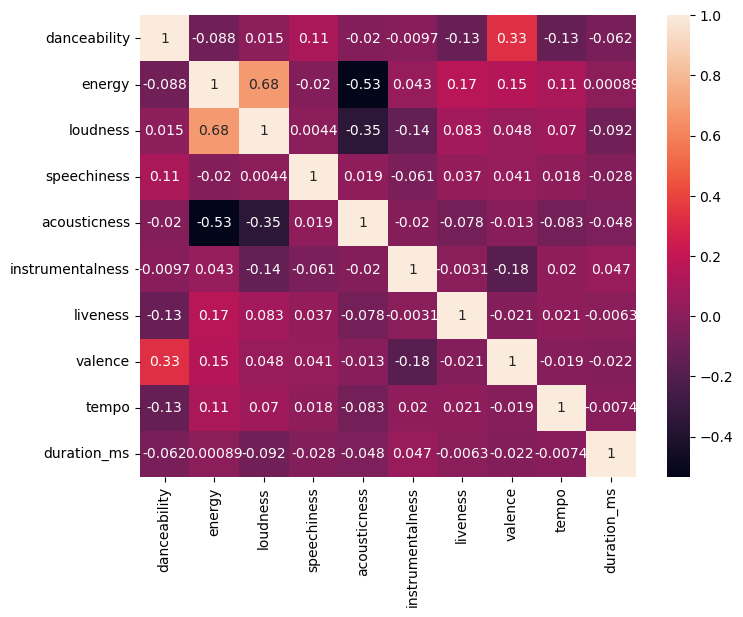

In [43]:
plt.figure(figsize=(8,6))
sns.heatmap(df[continuous_vars].corr(),annot=True);

La corrélation la plus forte que nous observons est entre `energy` et `acousticness`. Celle-ci est de -0.53, ce chiffre est assez élevé et pourrait nous permettre de laisser de côté l'une de ces deux colonnes, néanmoins nous choisissons de la garder. En effet, normalement on considère qu'un colonne peut être supprimer si la corrélation est supérieure  à 0.8. (cf. Dormann et al. (2013))

Pour mieux visualiser les écarts entre les différentes variables dans la prédiction du genree, nous allons tracer des boxplots

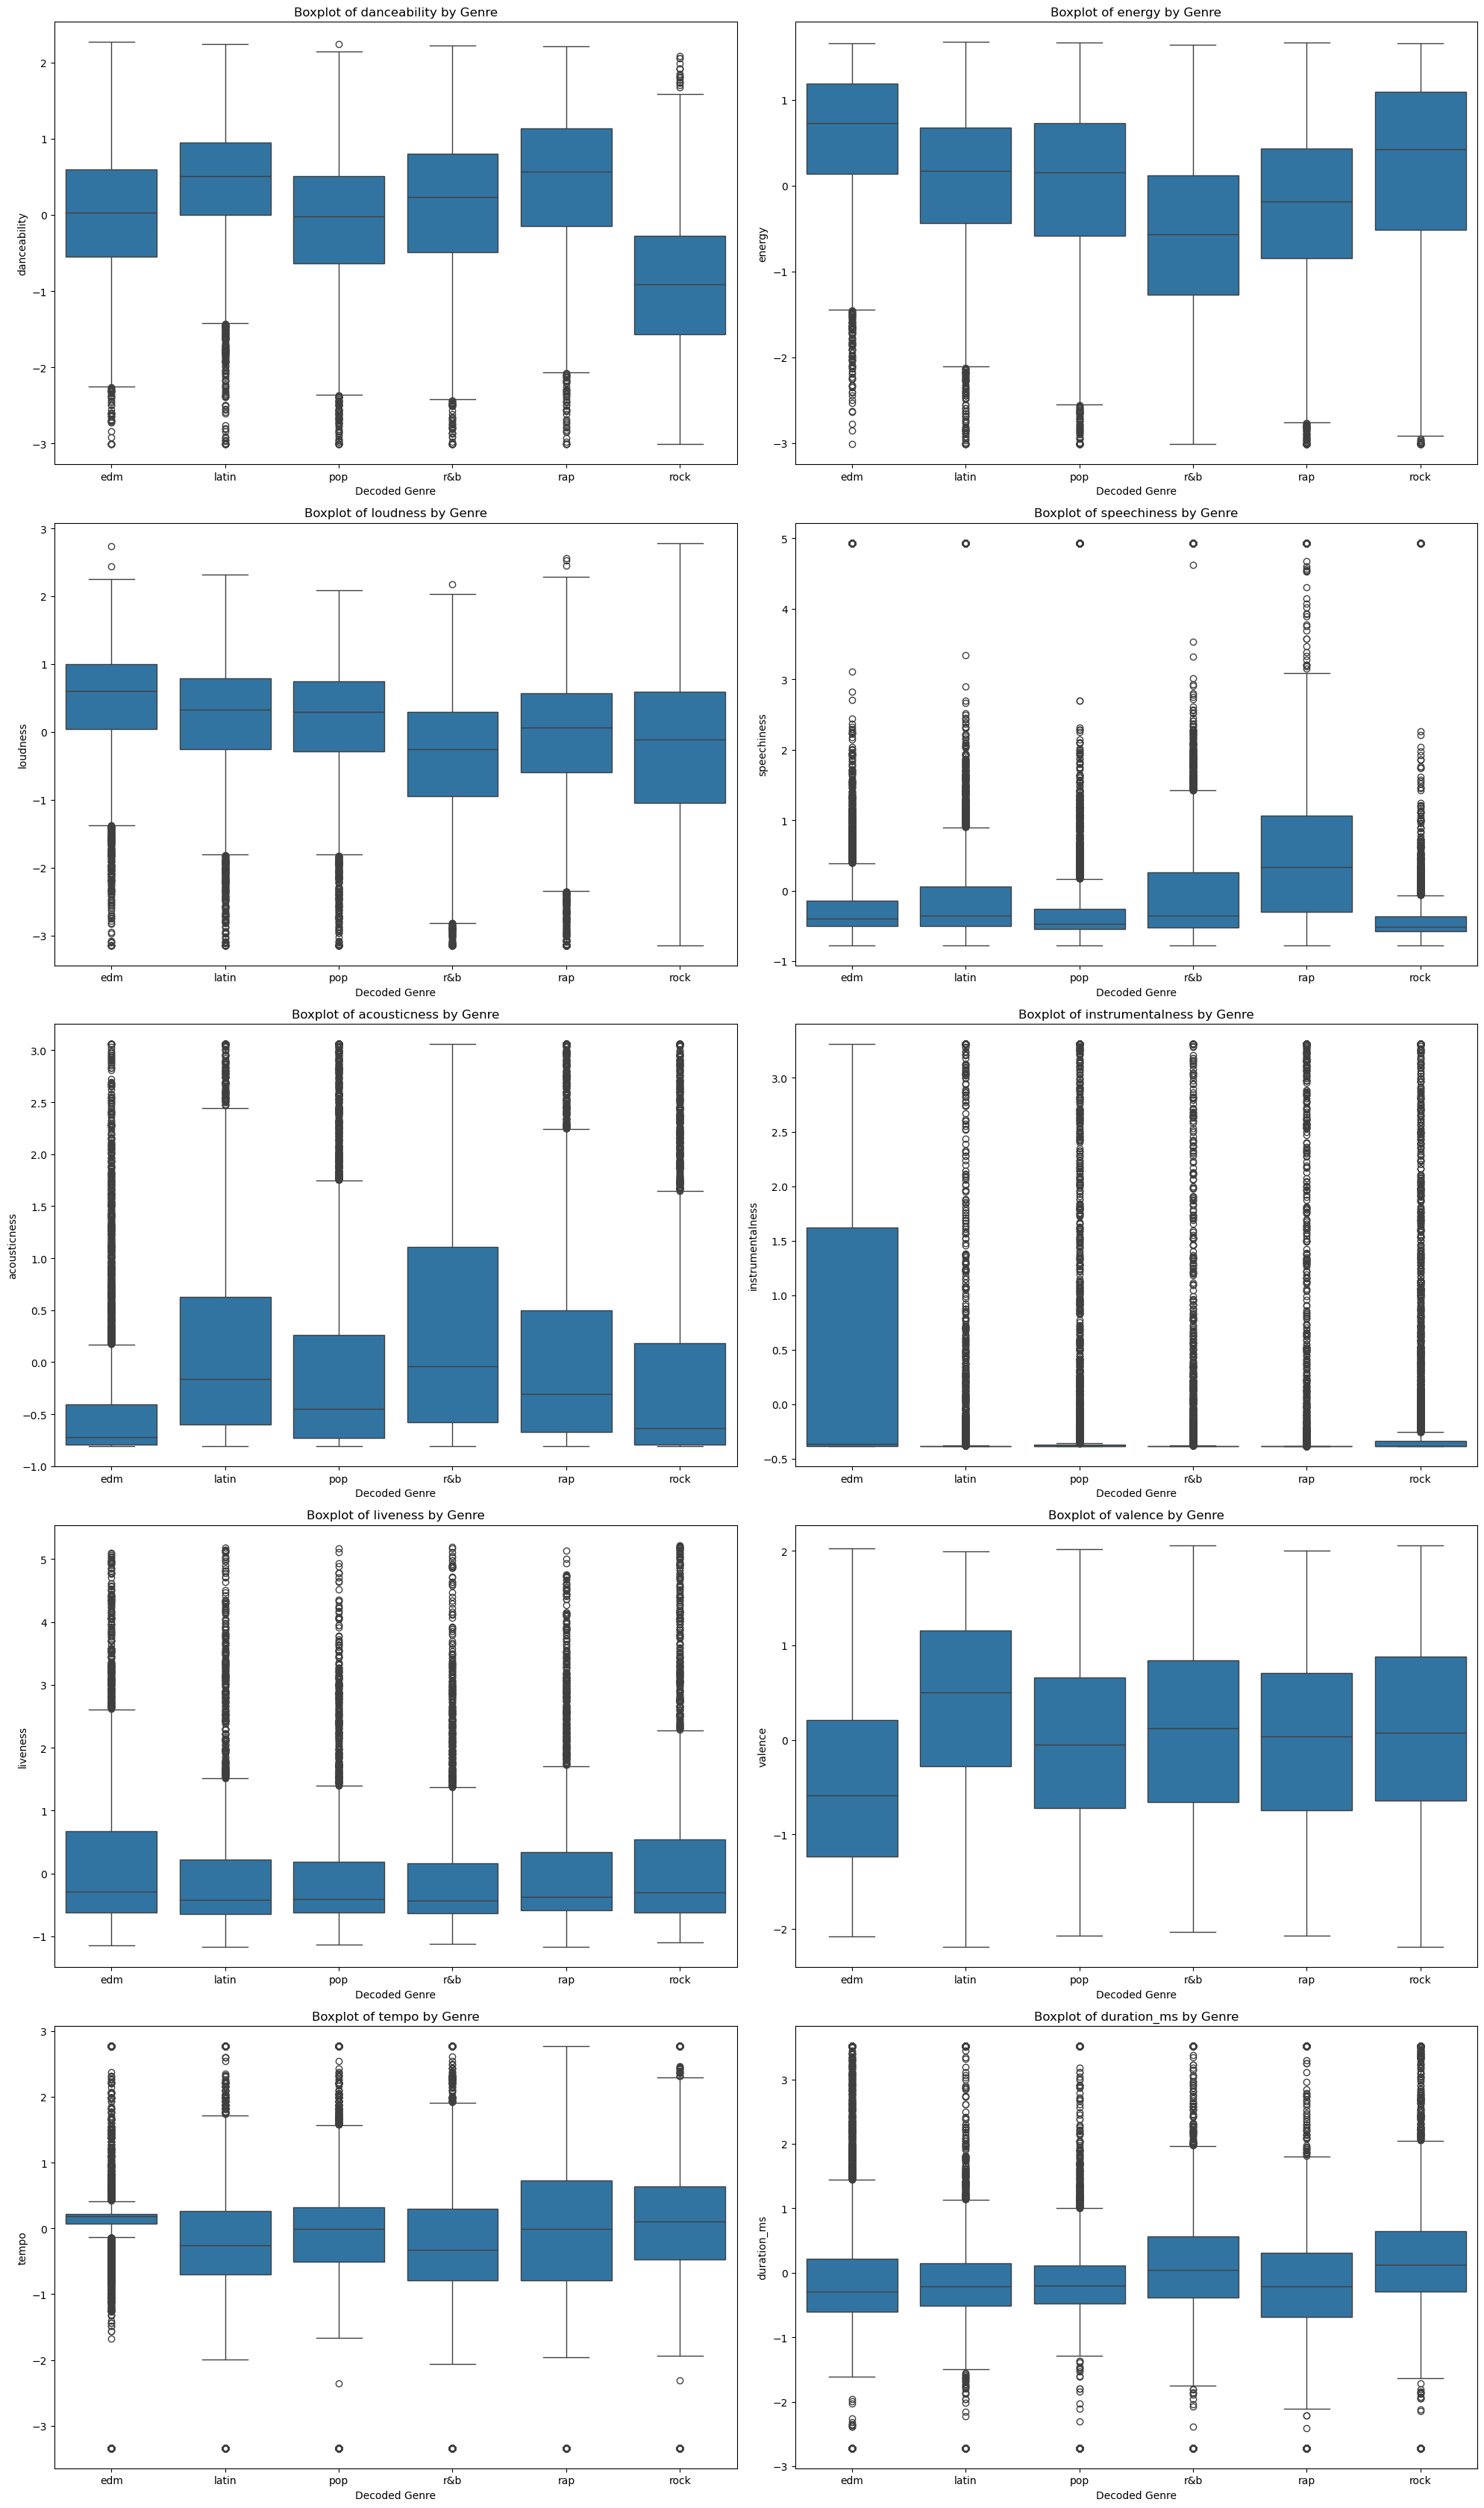

In [44]:
plt.figure(figsize=(20, 40))

for i, var in enumerate(continuous_vars):
    plt.subplot(6, 2, i+1)
    sns.boxplot(x='playlist_genre', y=var, data=df)
    plt.title(f'Boxplot of {var} by Genre')
    plt.xlabel('Decoded Genre')
    plt.ylabel(var)

plt.tight_layout()
plt.show()


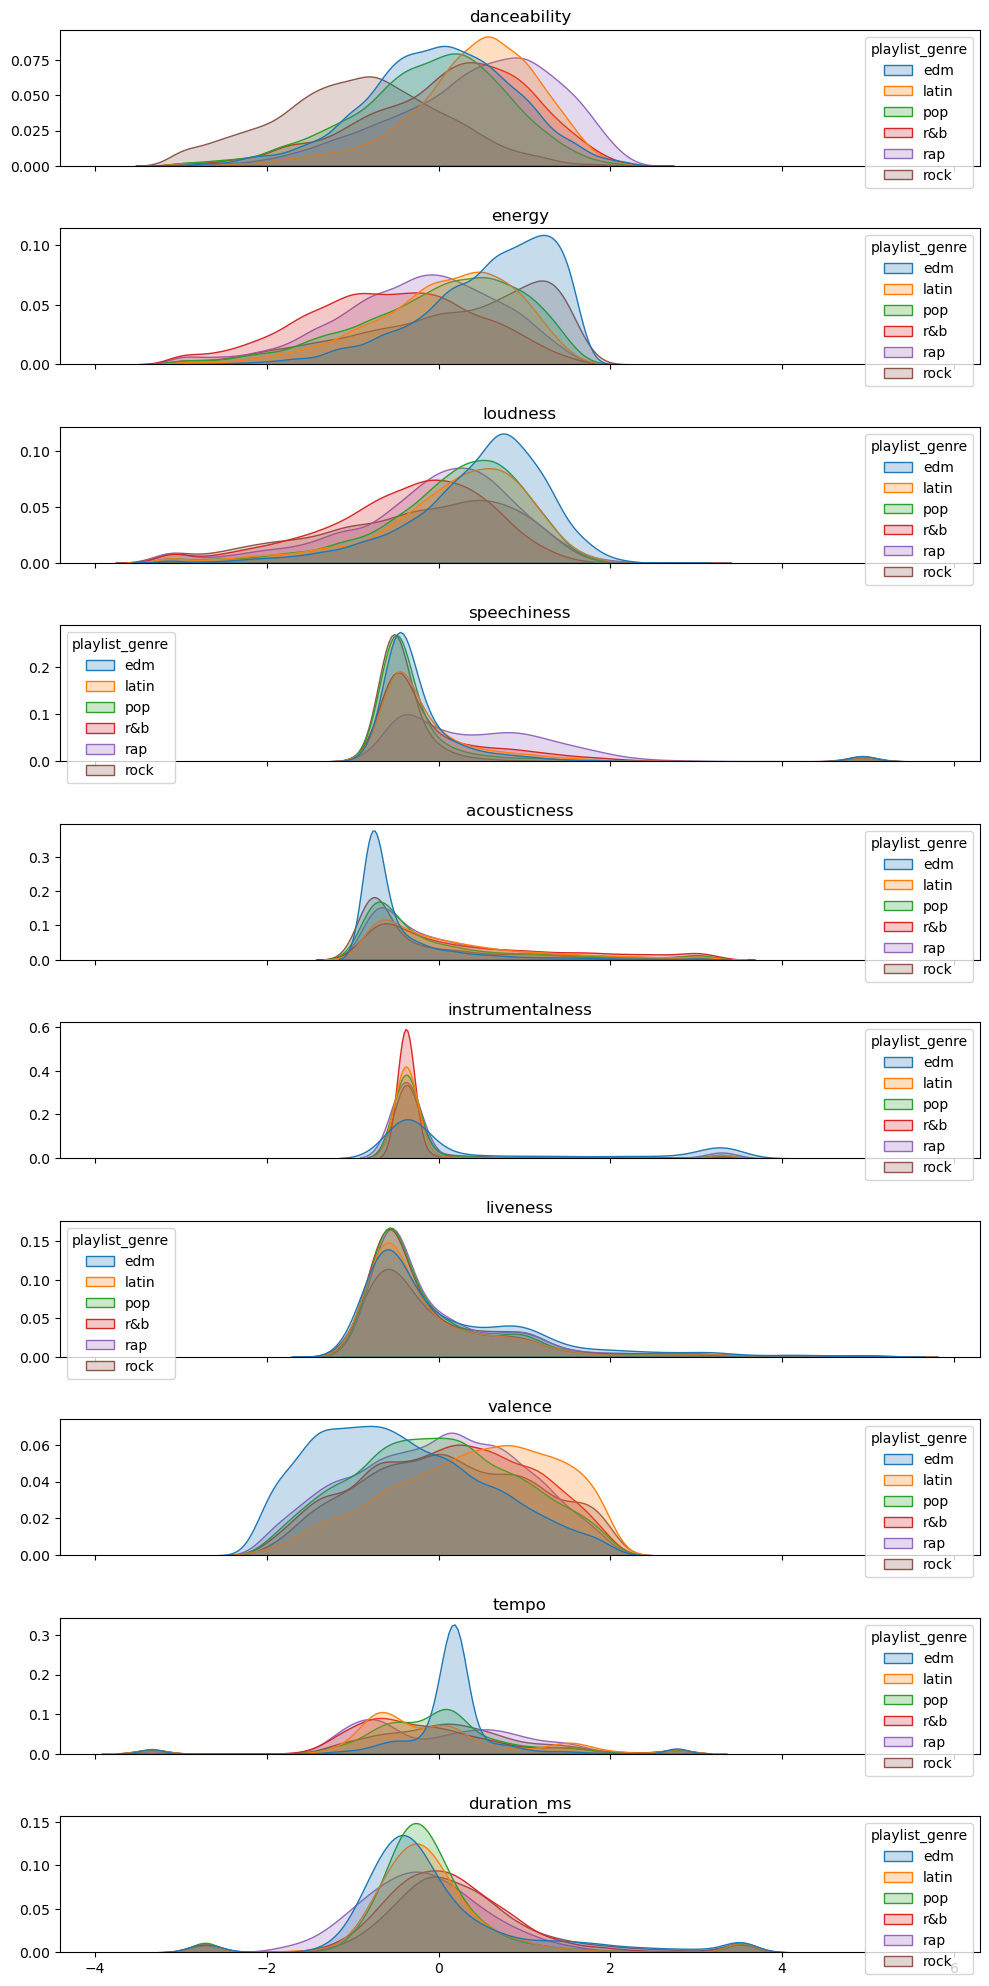

In [45]:
fig, axes = plt.subplots(len(continuous_vars),sharex=True, figsize=(10,20))

for ax, var in zip(axes, continuous_vars):
  sns.kdeplot(data=df, x=var, hue="playlist_genre", fill="playlist_genre",ax=ax);
  ax.set_title(var)
  ax.set_xlabel("")
  ax.set_ylabel("")

plt.tight_layout()

- Le niveau de `danceability` est assez élevé pour les genres EDM et Latin. A l'inverse, le genre Rock semble avoir une médiane plus basse, indiquant que les chansons rock sont globalement moins dansantes. Les genres Pop, Rap et R&B montrent une distribution similaire avec une médiane modérée. Cela peut être dû au fait que ces dernières musiques sont des genres récents et que la frontière entre les genres est plus fine aujourd'hui.

- `EDM` a l'énergie la plus élevée, avec une médiane haute une distribution très concentrée. C'est en effet un genre de musique très rythmé. `Rock`, `Rap` 
et `Latin` montrent également une bonne énergie, tandis que `Pop` et `R&B` ont des niveaux plus modérés. En effet, ce type de chansons est souvent plus calme.

- `Rap` présente une valeur élevée de "speechiness", ce qui est attendu étant donné que ce genre repose beaucoup sur les paroles.

- `EDM` et `Rock` sont les genres les plus bruyants ce qui est cohérent. La plage de valeurs est plus large pour `Pop` et `Rap`. Cela démontre que ces genres peuvent être parfois calmes et parfois plus énergiques, observation que l'on retrouvait sur la variable energy

- `Rap` présente une valeur élevée de "speechiness", ce qui est attendu étant donné que ce genre repose beaucoup sur les paroles.

- Les chansons de `R&B` et `Latin` sont souvent plus acoustiques. Alors que `EDM` est très électronique (valeur proche de 0 pour acousticness) ce qui fait sens.

- la `liveness` est proche de 0 ce qui montre que les musiques sont quasiment toutes des versions studio

En conclusion les genres musicaux semblent montrer des tendances claires dans leur répartition, par exemple:

- EDM est énergique, rapide et souvent instrumental.
- Rap se distingue par une "speechiness" élevée 
- Latin est dansant, joyeux, et acoustique.

Ces tendances permettent d'identifier des différences claires entre les genres de musique ce qui nous permettra de mener à bien la classification lors de la phase de modélisation.


### II.2.b. Vérification du poids des variables

Pour vérifier si nous ne pourrions pas enlever des variables, nous allons mener une ACP et un random Forest simplement pour savoir le poids que ce modèle attribue à chaque variable

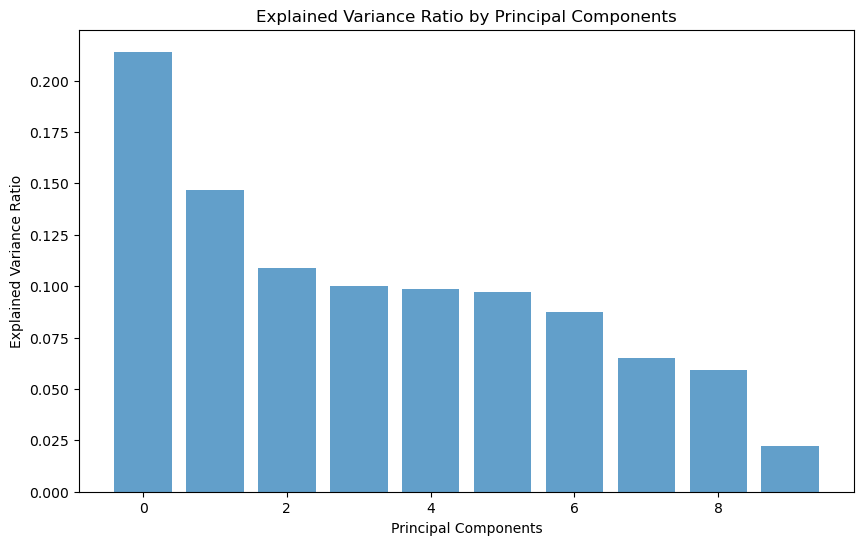

In [46]:
df_pca=df[continuous_vars]
# Perform PCA
pca = PCA()
pca.fit(df_pca)
# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_
# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.7, align='center')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

L'ACP ne nous permet pas de réduire notre dataframe à quelques composantes principales, en effet, les deux premières composantes n'incluent qu'une faible part d'explication de la variance. Cela se traduit aussi dans la part de chaque varible dans les composantes principales tracée ci-dessous:

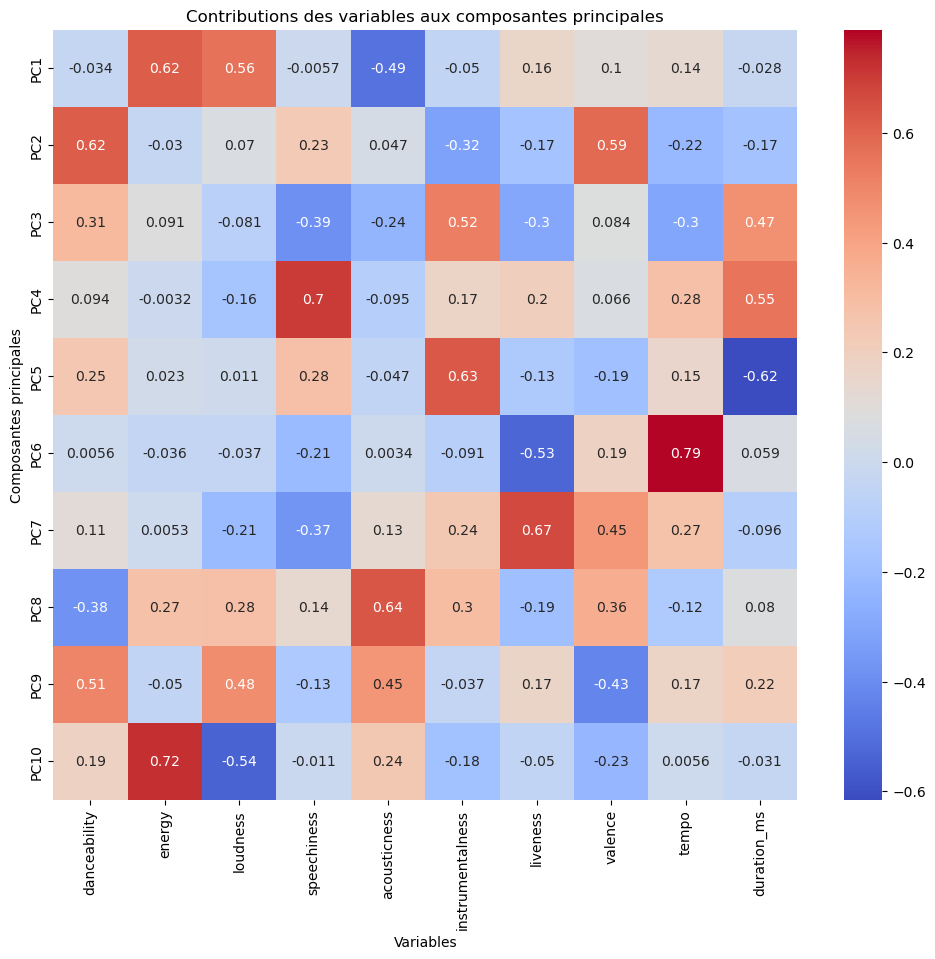

In [47]:
components = pd.DataFrame(pca.components_, columns=df_pca.columns)
plt.figure(figsize=(12, 10))
sns.heatmap(components, annot=True, cmap='coolwarm', xticklabels=df_pca.columns, yticklabels=[f'PC{i+1}' for i in range(len(components))])
plt.title("Contributions des variables aux composantes principales")
plt.xlabel("Variables")
plt.ylabel("Composantes principales")
plt.show()

Afin de vérifier si des composantes qualitatives pourraient être supprimées, nous réalisons un random Forest pour évaluer le poids de chaque variable: 

In [48]:
# Séparer les caractéristiques (features) et la cible (target)
X = df.drop('playlist_genre', axis=1)
y = df['playlist_genre']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Extraire l'importance des variables
importances = model.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les importances
print(importance_df)

                      Feature  Importance
12  playlist_subgenre_encoded    0.427640
0                danceability    0.071935
5                 speechiness    0.070176
10                      tempo    0.065221
1                      energy    0.059102
6                acousticness    0.052098
9                     valence    0.050388
3                    loudness    0.049529
11                duration_ms    0.048618
7            instrumentalness    0.045092
8                    liveness    0.032166
2                         key    0.021169
4                        mode    0.006866


playlist_subgenre_encoded occupe une importance forte, nous pourrions n'utiliser que cette variable pour notre étude. Cependant, cette variable contient en réalité l'information du genre, nous allons donc la supprimer du dataframe.

In [49]:
df=df.drop(['playlist_subgenre_encoded'],axis=1)

In [50]:
# Séparer les caractéristiques (features) et la cible (target)
X = df.drop('playlist_genre', axis=1)
y = df['playlist_genre']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Extraire l'importance des variables
importances = model.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les importances
print(importance_df)

             Feature  Importance
10             tempo    0.116596
0       danceability    0.114382
5        speechiness    0.110899
1             energy    0.097957
9            valence    0.092772
6       acousticness    0.090291
11       duration_ms    0.087686
3           loudness    0.086783
7   instrumentalness    0.073452
8           liveness    0.070122
2                key    0.045160
4               mode    0.013902


Nous pourrions supprimer certaines variables comme mode, key et liveness mais nous allons pour l'instant les garder dans notre modèle.

## II.3. Modélisation

In [51]:
file_path = "/ponte/Projet_data/data_tracks_cleaned.csv"

df = pd.read_csv("https://minio.lab.sspcloud.fr" + file_path)
df=df.drop(['playlist_subgenre_encoded'],axis=1)


### II.3.a. Random Forest

Tout d'abord, nous séparons la variable cible (le genre) des autres variables. Ensuite, nous divisons ces ensembles en deux parties : une pour entraîner le modèle et une autre pour le tester. Étant donné que notre jeu de données est organisé par genre, nous spécifions qu'il doit être divisé aléatoirement en utilisant l'argument `shuffle=True`.

In [52]:
features = df.copy()

genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.2, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Training Features Shape: (26266, 12)
Training Genres Shape: (26266,)
Testing Features Shape: (6567, 12)
Testing Genres Shape: (6567,)


Comme détaillé dans le notebook final_notebook, nous avons procédé à un ajustement des hyperparamètres du modèle, nous pouvons directement entraîner l'algorithme de random Forest avec les bons hyperparamètres.  

In [53]:
rf = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

rf.fit(train_features, train_genres)

predictions = rf.predict(test_features)


errors = zero_one_loss(test_genres, predictions, normalize=True)
print('zero_one_loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, test_genres))

zero_one_loss error normalized: 0.44723618090452266
accuracy_score on test dataset : 0.5527638190954773
              precision    recall  f1-score   support

         edm       0.68      0.66      0.67      1275
       latin       0.40      0.52      0.45       789
         pop       0.34      0.36      0.35      1014
         r&b       0.47      0.48      0.47      1048
         rap       0.65      0.57      0.61      1305
        rock       0.77      0.66      0.71      1136

    accuracy                           0.55      6567
   macro avg       0.55      0.54      0.54      6567
weighted avg       0.57      0.55      0.56      6567



Nous obtenons une accuracy de 55,2% ce qui est satisfaisant. Toutefois, nous allons plotter la matrice de confusion pour visualiser les différentes erreurs

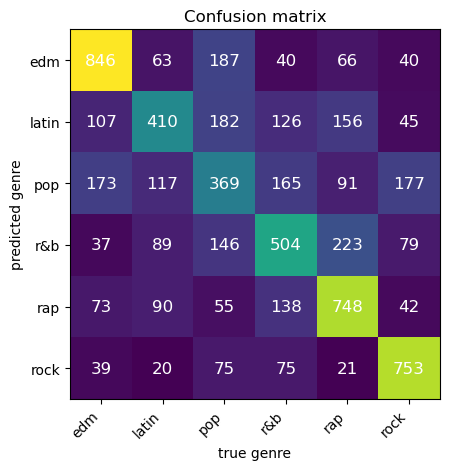

In [54]:
mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Nous arrivons à bien prédire les genres rap, rock et edm et moins bien pop latin et r&b

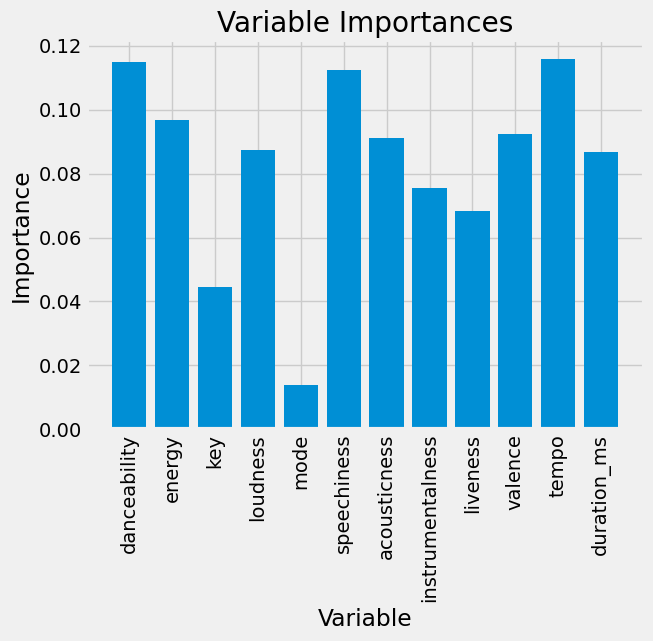

In [55]:
#Feature importances
plt.style.use('fivethirtyeight')

importances = list(rf.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Enfin, nous traçons l'importance de chaque caractéristique. Nous observons que les variables `key` et `mode` ne sont pas très utiles pour la prédiction. Cela est attendu, car ces variables varient relativement peu et ne sont pas fortement liées à chaque genre.  

Ainsi, notre modèle Random Forest atteint une précision de 55,2 %, ce qui est satisfaisant. Cependant, il montre de mauvaises performances pour identifier les genres latin, pop et R&B, qui sont très répandus dans le monde musical, tandis qu'il excelle dans l'identification du genre edm, rap et rock. Cela semble logique car la frontière en latin, pop et r&b est parfois ténue et des morceaux peuvent être des hybrides entre deux genres. Cela est beaucoup moins le cas pour edm, rap et rock. 

### II.3.b XGBoost

Afin de réaliser une modélisation avec XGBoost, il est nécessaire d'encoder nos variables, nous pourrions utiliser un module déjà implementé. Néanmoins, afin de conserver notre encodage et au vu de notre faible nombre de valeurs prises par notre variable cible, nous codons l'encodage.

In [56]:
features = df.copy()

def genre_to_num(genre):
    if genre == 'edm':
        return 0
    if genre == 'latin':
        return 1
    if genre == 'pop':
        return 2
    if genre == 'r&b':
        return 3
    if genre == 'rap':
        return 4
    if genre == 'rock':
        return 5

features['playlist_genre'] = features['playlist_genre'].apply(genre_to_num)

In [57]:
# isolation of the feature to predict
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Training Features Shape: (24624, 12)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 12)
Testing Genres Shape: (8209,)


Entrainement du modèle

In [58]:
model_xgb = XGBClassifier(objective='multi:softprob', colsample_bylevel=1, colsample_bytree=1, 
                          gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=20, min_child_weight=1, 
                          n_estimators=300, subsample=0.8, random_state = 42)

model_xgb.fit(train_features, train_genres)

predict_test = model_xgb.predict(test_features)
 

accuracy_test = accuracy_score(test_genres, predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)
print(classification_report(predict_test, test_genres))


accuracy_score on test dataset :  0.5529297112924838
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1581
           1       0.41      0.50      0.45      1078
           2       0.34      0.36      0.35      1267
           3       0.48      0.48      0.48      1318
           4       0.65      0.59      0.62      1575
           5       0.75      0.67      0.71      1390

    accuracy                           0.55      8209
   macro avg       0.55      0.54      0.55      8209
weighted avg       0.56      0.55      0.56      8209



Nous obtenons une accuracy de 55,3% ce qui est très similaire à la random forest. Cependant, le temps de calcul est netemment plus rapide ce qui est intéressant du point de vue du coût computationnel. De plus, le modèle est beaucoup plus léger (quelques mégas contre quelqués gigas pour random forest)


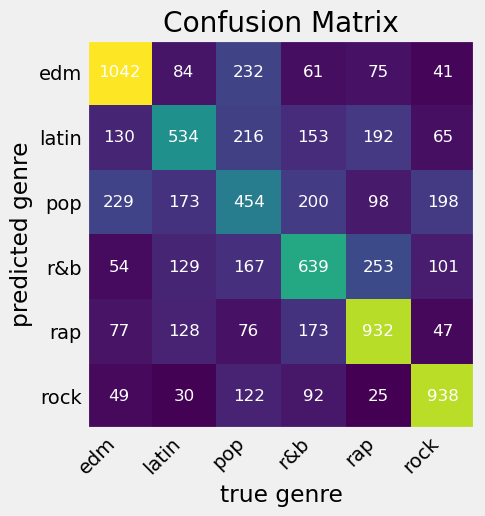

In [59]:
# Confusion matrix
mat = confusion_matrix(test_genres, predict_test)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Comme avec Random Forest, nous prédisons bien edm, rap et rock mais moins bien latin, pop et r&b

### II.3.c. Catboost

Comme précédemment, les hyperparamètres du modèle sont déjà calibrés

In [60]:
# Copy features
features = df.copy()

# Isolate the target variable
genres = np.array(features['playlist_genre'])
features = features.drop(['playlist_genre'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# Split into training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Training Features Shape: (24624, 12)
Training Genres Shape: (24624,)
Testing Features Shape: (8209, 12)
Testing Genres Shape: (8209,)


In [61]:
model = CatBoostClassifier(learning_rate=0.05,l2_leaf_reg=1,n_estimators=1000,depth=5,border_count=64, 
                           cat_features=[], verbose=0)

# Train the model
model.fit(train_features, train_genres)

# Predictions
predictions = model.predict(test_features)

# Zero-One Loss Error
errors = zero_one_loss(test_genres, predictions, normalize=True)
print('Zero-One Loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('Accuracy score on test dataset:', accuracy_test)

# Classification Report
print(classification_report(test_genres, predictions))

Zero-One Loss error normalized: 0.4404921427701304
Accuracy score on test dataset: 0.5595078572298696
              precision    recall  f1-score   support

         edm       0.68      0.69      0.69      1535
       latin       0.49      0.39      0.43      1290
         pop       0.38      0.36      0.37      1352
         r&b       0.49      0.48      0.48      1343
         rap       0.59      0.68      0.63      1433
        rock       0.66      0.74      0.70      1256

    accuracy                           0.56      8209
   macro avg       0.55      0.56      0.55      8209
weighted avg       0.55      0.56      0.55      8209



Nous obtenons une accuracy de 56% ce qui est proche des résultats précédents

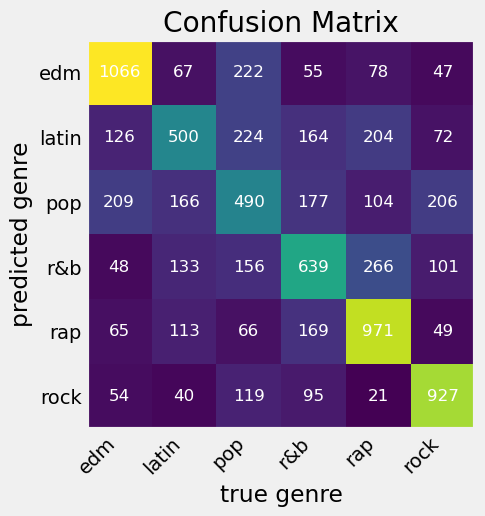

In [62]:
# Confusion matrix

mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['edm','latin','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Encore une fois, les gens les mieux prédits sont edm, rap et rock et les moins bien prédits sont latin pop et r&b

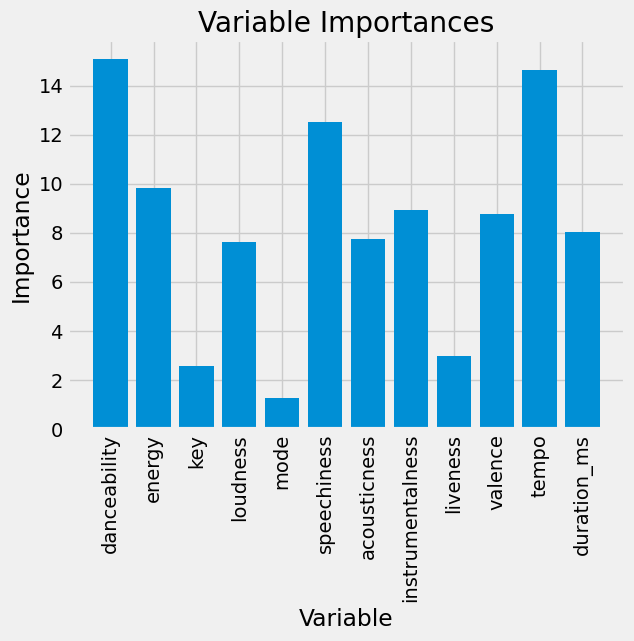

In [63]:
# Feature importances
plt.style.use('fivethirtyeight')

importances = list(model.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

# Conclusion

Nous avons été en mesure de prédire le genre d'une musique à l'aide de quelques caractéristiques audio avec une précision de 56%. Ce résultat est encourageant au vu de la taille réduite de notre dataset d'entraînement.

Nous avons testé trois modèles : Random Forest, XGBoost et CatBoost, qui ont tous donné des résultats similaires et globalement satisfaisants. Néanmoins, le coût temporel et spatial diffère fortement selon ces modèles. En effet, random forest occupe un espace et demande des calculs beaucoup plus importants que les deux autres. Ces approches seraient donc celles à prioriser.

Une piste d'amélioration serait une meilleure prédiction des genres pop et R&B. Cependant, le principal défi de notre projet semble résider dans le fait que l'attribution d'un genre musical est intrinsèquement subjective, ce qui se reflète dans les caractéristiques communes des genres comme le pop et le R&B.